### DataSaving.py

In [1]:
import numpy as np

class DataSaving():
    loss=[]

    def __init__(self) -> None:
        pass
    def addLoss(self,l):
        self.loss.append(l)
    def saveLoss(self,filename):
        with open(f'{filename}.txt','w') as f:
            for i in range(len(self.loss)):
                f.write(f'{self.loss[i]} ')
    def save(filepath,way,parameter:np.ndarray,dime=2):
        '''
        '''
        with open(filepath,way) as f:
            if dime == 1:
                for i in range(len(parameter)):
                    if i == len(parameter)-1:
                        f.write(f'{parameter[i]}\n')
                    else:
                        f.write(f'{parameter[i]},')
            elif dime == 2:
                x,y=parameter.shape
                for i in range(x):
                    for j in range(y):
                        if i == y-1:
                            f.write(f'{parameter[i][j]}\n')
                        else:
                            f.write(f'{parameter[i][j]},')
                    print('\n')

### DataProcessing.py
侧滑角	马赫数	来流静压	迎角

In [2]:
import torch
import numpy as np
import pandas as pd

def getData(filepath:str,prec=torch.float32):

    #---pandas 读取 xlsx 文件
    source=pd.read_excel(filepath)
    data=source.values

    x,_=data.shape
    #---截取 特征部分
    train_features=data[:int(x*0.8),:8]
    verif_features=data[int(x*0.8):,:8]
    #---截取 标签部分
    train_labels=np.array([data[:int(x*0.8),0]]).T
    verif_labels=np.array([data[int(x*0.8):,0]]).T

    train_features=torch.from_numpy(train_features).to(prec)
    verif_features=torch.from_numpy(verif_features).to(prec)
    train_labels=torch.from_numpy(train_labels).to(prec)
    verif_labels=torch.from_numpy(verif_labels).to(prec)

    return train_features,train_labels,verif_features,verif_labels
train_features,train_labels,verif_features,verif_labels=getData('../data/result/SideslipAngle.xlsx')

In [3]:
import torch
import numpy as np

def dataIter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [4]:
def squareLoss(y_hat, y):
    """MSE"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [5]:
# import torch
# from torch import nn

# batchSize=8
# epochSize=20

# lr=0.0001
# OrigD=8
# DestD=1
# HideD=4

# WQ=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)
# WK=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)
# WV=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)

# W1 = nn.Parameter(torch.randn(HideD, OrigD, requires_grad=True) * 1)
# b1 = nn.Parameter(torch.zeros(1,HideD, requires_grad=True))
# W2 = nn.Parameter(torch.randn(DestD, HideD, requires_grad=True) * 1)
# b2 = nn.Parameter(torch.zeros(1,DestD, requires_grad=True))

# X=torch.randn(batchSize, OrigD, requires_grad=True)
# I=X.sin()

# Q=WQ*I
# K=WK*I
# V=WV*I

# A=K.t()@Q
# softmax=nn.Softmax(dim=1)
# Ax=softmax(A)
# O=V@Ax

# # --- Mult Perce ---
# H = relu(W1@(O.T) + b1.T)
# Y=(W2@H + b2.T)

### Train and Test

In [6]:
import torch
from torch import nn

loss=squareLoss

def net(X,WQ,WK,WV,W1,b1,W2,b2):
    '''
    
    '''
    # --- Self Attention ---
    # I=X.sin()

    I=X
    
    Q=WQ*I
    K=WK*I
    V=WV*I

    A=K.t()@Q
    softmax=nn.Softmax(dim=1)
    Ax=softmax(A)
    O=V@Ax

    # --- Mult Perce ---
    H = relu(W1@(O.T) + b1.T)
    Y=(W2@H + b2.T)

    return Y.T

if __name__ == "__main__":
    '''

    '''
    batchSize=8
    epochSize=50

    lr=0.00001
    OrigD=8
    DestD=1
    HideD=16

    WQ=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)
    WK=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)
    WV=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 1)

    W1 = nn.Parameter(torch.randn(HideD, OrigD, requires_grad=True) * 1)
    b1 = nn.Parameter(torch.zeros(1,HideD, requires_grad=True))
    W2 = nn.Parameter(torch.randn(DestD, HideD, requires_grad=True) * 1)
    b2 = nn.Parameter(torch.zeros(1,DestD, requires_grad=True))

    # --- 数据读取 ---
    train_features,train_labels,verif_features,verif_labels=getData('../data/result/AngleofAttack.xlsx')
    
    for epoch in range(epochSize):
        for X, y in dataIter(batchSize, train_features, train_labels):
            # --- X和y的小批量损失 ---
            y_hat=net(X,WQ,WK,WV,W1,b1,W2,b2)
            l = loss(y_hat, y)
            # --- 反向传播，计算梯度 ---
            l.sum().backward()
            # --- 使用参数的梯度更新参数 ---
            sgd([WQ,WK,WV,W1,b1,W2,b2], lr, batchSize)
        with torch.no_grad():
            train_l = loss(net(verif_features,WQ,WK,WV,W1,b1,W2,b2),verif_labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    torch.save(WQ,'../result/WQ')
    torch.save(WK,'../result/WK')
    torch.save(WV,'../result/WV')

    torch.save(W1,'../result/W1')
    torch.save(W2,'../result/W2')
    torch.save(b1,'../result/b1')
    torch.save(b2,'../result/b2')    

epoch 1, loss 0.826890
epoch 2, loss 0.910277
epoch 3, loss 0.961101
epoch 4, loss 0.989944
epoch 5, loss 1.010225
epoch 6, loss 1.020990
epoch 7, loss 1.023550
epoch 8, loss 1.027565
epoch 9, loss 1.027419
epoch 10, loss 1.026592
epoch 11, loss 1.025902
epoch 12, loss 1.020126


KeyboardInterrupt: 

### Predict

In [7]:
WQ=torch.load('../result/WQ')
WK=torch.load('../result/WK')
WV=torch.load('../result/WV')
W1=torch.load('../result/W1')
W2=torch.load('../result/W2')
b1=torch.load('../result/b1')
b2=torch.load('../result/b2')
X=torch.tensor([[0.402001281,0.342326603,0.212043361,0.308767707,0.175532454,0.163157033,0.147027114,0.10561953]])
result=net(X,WQ,WK,WV,W1,b1,W2,b2)
print(result)

tensor([[0.2702]], grad_fn=<PermuteBackward0>)


In [26]:
Y=torch.tensor([[8,1.7,54048.3,-10]])
y=Y.T

In [9]:
print(result)

tensor([[0.7615]], grad_fn=<PermuteBackward0>)


In [10]:
print(0.7614696026*40-20)

10.458784104


In [9]:
print(0.487601608*1.7+0.3)

1.1289227336


In [10]:
print(0.4237176478*(107478-6467.5)+6467.5)

49267.4314631019


In [8]:
print(0.2934017479*(30)-10)

tensor([[-1.8942]], grad_fn=<SubBackward0>)


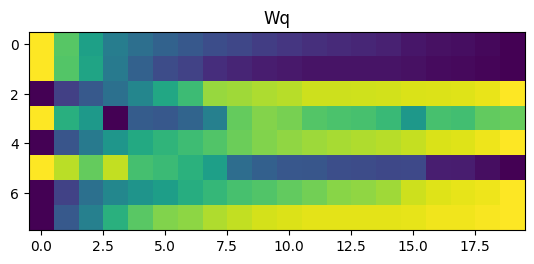

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt

# if __name__ == "__main__":
#     '''
#     '''
#     data=pd.read_csv('../data/result/WQ.txt')
#     data=data.values.T

#     # for i in range(12):
#     #     data.loc[:,i]=(data.loc[:,i]-data.loc[:,i].min())/(data.loc[:,i].max()-data.loc[:,i].min())
#     # --- Min-Max Normalization ---
#     for i in range(len(data)):
#         min_val = data[i].min()
#         max_val = data[i].max()
        
#         # data[i] = (data[i] - min_val) / (max_val - min_val)
#     # data=data.values
#     # plt.imshow(data)
#     # plt.title('Wq')

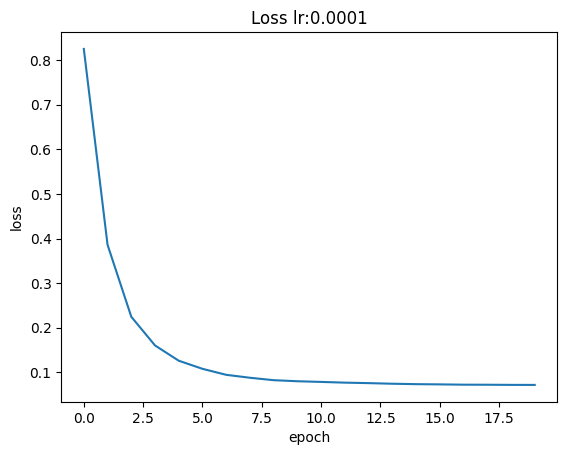

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
if __name__ == "__main__":
    fig = plt.figure()
    plt.title('Loss with self attention lr:0.0001')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    ims = []
    X=[]
    x=[0.825105
,  0.385919
,  0.224624
,  0.160336
,  0.126073
,  0.107923
,  0.094480
,  0.087892
,  0.082446
,  0.080087
,  0.078556
,  0.076952
,  0.075852
,  0.074495
,  0.073537
,  0.073048
,  0.072378
,  0.072249
,  0.071930
,  0.071832]
    plt.plot(x)
    # for i in range(len(x)):
    #     X.append(x[i])
    #     im=plt.plot(X)
    #     # im = plt.plot(np.linspace(0, i,10), np.linspace(0, np.random.randint(i),10))
    #     ims.append(im)
    # ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000)
    # ani.save("../data/result/loss.gif",writer='pillow')


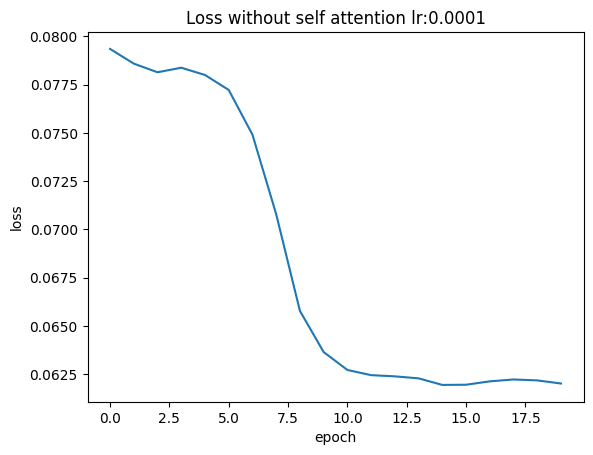

In [6]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
if __name__ == "__main__":
    fig = plt.figure()
    plt.title('Loss without self attention lr:0.0001')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    ims = []
    X=[]
    x=[
0.079346
,0.078584
,0.078137
,0.078373
,0.077996
,0.077220
,0.074903
,0.070784
,0.065776
,0.063646
,0.062718
,0.062450
,0.062388
,0.062284
,0.061944
,0.061954
,0.062129
,0.062226
,0.062178
,0.062017]
    plt.plot(x)
    # for i in range(len(x)):
    #     X.append(x[i])
    #     im=plt.plot(X)
    #     # im = plt.plot(np.linspace(0, i,10), np.linspace(0, np.random.randint(i),10))
    #     ims.append(im)
    # ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000)
    # ani.save("../data/result/loss.gif",writer='pillow')


In [ ]:
# import torch
# from torch import nn
# from DEP import getData
# from DEP import dataIter
# from DEP import relu
# from DEP import sgd
# from DEP import squareLoss as loss

# def net(X,kernel,WQ,WK,WV,W1,b1,W2,b2):
#     '''
    
#     '''
#     # --- Self Attention ---
#     I=X.sin()

#     Q=WQ*I
#     K=WK*I
#     V=WV*I

#     A=K.t()@Q
#     softmax=nn.Softmax(dim=1)
#     Ax=softmax(A)
#     O=V@Ax

#     # --- One dime Kernel ---
#     Z=kernel*O

#     # --- Mult Perce ---
#     H = relu(W1@(Z.T) + b1.T)
#     Y=(W2@H + b2.T)

#     return Y

# if __name__ == "__main__":
#     '''

#     '''
    
#     batchSize=4
#     epochSize=10

#     lr=0.01
#     OrigD=8
#     DestD=4
#     HideD=4

#     kernel=nn.Parameter(torch.tensor(1.,requires_grad=True))

#     WQ=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)
#     WK=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)
#     WV=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)

#     W1 = nn.Parameter(torch.randn(HideD, OrigD, requires_grad=True) * 5)
#     b1 = nn.Parameter(torch.zeros(1,HideD, requires_grad=True))
#     W2 = nn.Parameter(torch.randn(DestD, HideD, requires_grad=True) * 5)
#     b2 = nn.Parameter(torch.zeros(1,DestD, requires_grad=True))

#     # --- 数据读取 ---
#     train_features,train_labels,_=getData('../data/train_data.xlsx')
#     test_features,test_labels,_=getData('../data/test_data.xlsx')

#     for epoch in range(epochSize):
#         print(kernel)
#         for X, y in dataIter(batchSize, train_features, train_labels):
#             # --- X和y的小批量损失 ---
#             l = loss(net(X,kernel,WQ,WK,WV,W1,b1,W2,b2), y)
#             # --- 反向传播，计算梯度 ---
#             l.sum().backward()
#             # --- 使用参数的梯度更新参数 ---
#             sgd([kernel,WQ,WK,WV,W1,b1,W2,b2], lr, batchSize)
#         with torch.no_grad():
#             train_l = loss(net(test_features.mean(axis=0),kernel,WQ,WK,WV,W1,b1,W2,b2), test_labels.mean(axis=0))
#             print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

In [5]:
import torch
import time
import numpy as np
from torch import nn
from DEP import Record
from DEP import getData
from DEP import dataIter
from DEP import relu
from DEP import sgd
from DEP import squareLoss as loss

def net(X,WQ,WK,WV,W1,b1,W2,b2):
    '''
    
    '''
    # --- Self Attention ---
    # I=X.sin()

    # Q=WQ*I
    # K=WK*I
    # V=WV*I

    # A=K.t()@Q
    # softmax=nn.Softmax(dim=1)
    # Ax=softmax(A)
    # O=V@Ax

    # # --- Mult Perce ---
    # H = relu(W1@(O.T) + b1.T)
    # Y=(W2@H + b2.T)

    # return Y
    I=X
    
    Q=WQ*I
    K=WK*I
    V=WV*I

    A=K.t()@Q
    softmax=nn.Softmax(dim=1)
    Ax=softmax(A)
    O=V@Ax

    # --- Mult Perce ---
    H = relu(W1@(O.T) + b1.T)
    Y=(W2@H + b2.T)

    return Y.T

if __name__ == "__main__":
    '''

    '''
    batchSize=8
    epochSize=10

    lr=0.0001
    OrigD=8
    DestD=4
    HideD=4

    WQ=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)
    WK=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)
    WV=nn.Parameter(torch.randn(1,OrigD,requires_grad=True) * 5)

    W1 = nn.Parameter(torch.randn(HideD, OrigD, requires_grad=True) * 5)
    b1 = nn.Parameter(torch.zeros(1,HideD, requires_grad=True))
    W2 = nn.Parameter(torch.randn(DestD, HideD, requires_grad=True) * 5)
    b2 = nn.Parameter(torch.zeros(1,DestD, requires_grad=True))

    # --- 数据读取 ---
    train_features,train_labels,_=getData('../data/origin/train_data.xlsx')
    test_features,test_labels,_=getData('../data/origin/test_data.xlsx')
    
    record=Record()
    
    for epoch in range(epochSize):
        for X, y in dataIter(batchSize, train_features, train_labels):
            # --- X和y的小批量损失 ---
            l = loss(net(X,WQ,WK,WV,W1,b1,W2,b2), y)
            # --- 反向传播，计算梯度 ---
            l.sum().backward()
            # --- 使用参数的梯度更新参数 ---
            sgd([WQ,WK,WV,W1,b1,W2,b2], lr, batchSize)
        with torch.no_grad():
            train_l = loss(net(test_features,WQ,WK,WV,W1,b1,W2,b2), test_labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
            record.add(train_l.mean())
            record.savePara('../data/result/WQ',WQ.detach().numpy())
    record.saveLoss('../data/result/Loss')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [19]:
z=net(test_features,WQ,WK,WV,W1,b1,W2,b2)
z=z.mean(axis=1)
z=z.detach().numpy()

In [17]:
s=test_features.mean(axis=0)

In [5]:
print(WK,WK,WV,W1,b1,W2,b2)

Parameter containing:
tensor([[ 3.0884, -6.4803,  4.9852,  5.9869, -4.8233,  5.7545, -0.2335,  5.9662]],
       requires_grad=True)


In [2]:
feat=torch.tensor([0.95,0.823529412,0.8,0.006075657,0.009419246,0.01159108,0.030305886,0.031536561,0.034104969,0.011379024,0.007001902])
z=net(feat,WQ,WK,WV,W1,b1,W2,b2)

NameError: name 'torch' is not defined

In [32]:
import pandas as pd

if __name__ == "__main__":
    '''
    '''
    data=pd.read_excel('../data/original/total.xlsx')
    data=data.values
    data=data.T
    X=[]
    x=[5.8719344139,-1.777615428,0.4720406532,-2.4528055191,0.1816388369,0.1899358183,0.1815485954,0.158750385,0.2116764486,0.2287368923,0.2194380611,0.2153886408]
    # --- Min-Max Normalization ---
    for i in range(len(x)):
        min_val = data[i].min()
        max_val = data[i].max()
        s=x[i]*(max_val-min_val)+min_val
        X.append(s)
    print(X)

[214.877376556, -2.7219462276, 54148.562400058596, -83.584165573, 43477.61830034481, 43457.85276147312, 44365.42502117679, 41043.5853327393, 59299.41342418208, 64157.78546178384, 63085.23308641106, 58906.85052206694]


In [31]:

min_val=data[0].min()
max_val=data[0].max()
s=5.8719344139*(max_val-min_val)+min_val
print(s,min_val,max_val)

214.877376556 -20.0 20.0


In [33]:
h=torch.tensor([18,0.5,95461.3,8,92637.25193,91024.04597,92936.14641,97118.21165,98728.95406,94766.4384,87583.37797,92217.74637])


In [36]:
m = nn.Conv1d(in_channels=16, out_channels=33, kernel_size=3, stride=2)

input = torch.randn(20, 16, 50) # batch size 20,通道数16,序列长度50
output = m(input) # 卷积输出